In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb
!pip3 install cuda-python

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import AttackDetectionModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import shuffle

from bayes_opt import BayesianOptimization

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
importing Jupyter notebook from AttackDetectionModel.ipynb


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Data Pre-Processing

In [3]:
number_features = 35

In [4]:
df_benign, df_attack = AttackDetectionModel.get_files_botiot("../../botiot")

df_benign = np.concatenate([df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, 
                            df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, 
                            df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, 
                            df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign,
                            df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign])
df_benign = shuffle(df_benign)

In [5]:
# Normalize with the min-max scaler
scaler = MinMaxScaler()
df_benign_norm = scaler.fit_transform(df_benign)
df_attack_norm = scaler.fit_transform(df_attack)

# Sets

In [6]:
# Train
len_benign_train = int(0.7 * len(df_benign_norm))
X_train = df_benign_norm[:len_benign_train]

In [7]:
# Test
X_test_benign = df_benign_norm[len_benign_train:]
X_test = np.concatenate([X_test_benign, df_attack_norm])

Y_test = np.ones(len(X_test))
Y_test[:len(X_test_benign)] = 0

# Model

In [8]:
# Parameters
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

# Initial values
epochs = 5
learning_rate = 0.0001
batch_size = 10
anomaly_threshold = 0.05

# Dictionary
dict_params = { 'learning_rate': learning_rate, 'batch_size': round(batch_size), 'epochs': round(epochs)}
pbounds = { 'learning_rate': (0.000001, 0.001), 'batch_size': (10, 100), 'epochs': (50, 1000)}

In [9]:
# KL Loss function
def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [10]:
# Encoder
inputs, encoder, z_var, z_mean = AttackDetectionModel.vae_encoder(input_shape, 
                                                                  intermediate_dim, 
                                                                  latent_dim, 
                                                                  AttackDetectionModel.reparametrization)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 35)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 17)           612         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 11)           198         ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 11)           198         ['dense[0][0]']                  
                                                                                            

In [11]:
# Decoder
decoder = AttackDetectionModel.vae_decoder(intermediate_dim, latent_dim, original_dim)
outputs = decoder(encoder(inputs))
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 11)]              0         
                                                                 
 dense_1 (Dense)             (None, 17)                204       
                                                                 
 dense_2 (Dense)             (None, 35)                630       
                                                                 
Total params: 834
Trainable params: 834
Non-trainable params: 0
_________________________________________________________________


# Hyperparameter Optimization

In [12]:
def maximize_training(X_train = X_train, 
                      X_test = X_test, 
                      Y_test = Y_test, 
                      inputs = inputs, 
                      outputs = outputs, 
                      vae_loss = vae_loss,
                      learning_rate = learning_rate,
                      batch_size = batch_size,
                      epochs = epochs,
                      anomaly_threshold = anomaly_threshold):    
    
    # Create model
    opt_adam = optimizers.Adam(learning_rate = dict_params['learning_rate'], clipvalue = 0.5)
    model = Model(inputs, outputs, name = 'vae_mlp')
    model.compile(optimizer = opt_adam, loss = vae_loss)

    # Train
    history = model.fit(X_train, 
                        X_train, 
                        shuffle = True, 
                        verbose = 0,
                        epochs = dict_params['epochs'], 
                        batch_size = dict_params['batch_size'])
    
    # Maximize the f1-score
    X_pred_opt = model.predict(X_test)
    error_vector_opt = AttackDetectionModel.get_error_term(X_pred_opt, X_test, _rmse = False)
    Y_pred_opt = (error_vector_opt > anomaly_threshold)
    f1 = f1_score(Y_test, Y_pred_opt)
    
    return f1

In [13]:
'''
# Apply Bayesian optimization to choose the best hyperparameters

opt = BayesianOptimization(f = maximize_training,
                           pbounds = pbounds,
                           verbose = 2, 
                           random_state = 1)

opt_start = time.time()

opt.maximize(init_points = 5, n_iter = 5)

opt_end = time.time()
opt_time = opt_end - opt_start
print("Optimization time:", opt_time)

learning_rate = opt.max['params']['learning_rate']
epochs = round(opt.max['params']['epochs'])
batch_size = round(opt.max['params']['batch_size'])
'''

'\n# Apply Bayesian optimization to choose the best hyperparameters\n\nopt = BayesianOptimization(f = maximize_training,\n                           pbounds = pbounds,\n                           verbose = 2, \n                           random_state = 1)\n\nopt_start = time.time()\n\nopt.maximize(init_points = 5, n_iter = 5)\n\nopt_end = time.time()\nopt_time = opt_end - opt_start\nprint("Optimization time:", opt_time)\n\nlearning_rate = opt.max[\'params\'][\'learning_rate\']\nepochs = round(opt.max[\'params\'][\'epochs\'])\nbatch_size = round(opt.max[\'params\'][\'batch_size\'])\n'

# Predict Attacks

In [14]:
# Training step with the best hyperparameters
learning_rate = 0.0005007978127917845
epochs = 550
batch_size = 19
opt_time = 1151.2620151042938
anomaly_threshold = 0.043

In [15]:
for i in range(1):
    print("Iteration " + str(i))
    
    # Train
    vae_model, train_time = AttackDetectionModel.train(X_train, inputs, outputs, vae_loss, learning_rate, epochs, batch_size)
    
    # Set the optimized anomaly threshold
    #anomaly_threshold = AttackDetectionModel.get_anomaly_threshold(X_train, vae_model)
    
    # Test
    X_pred, test_time = AttackDetectionModel.test(X_test, vae_model)
    Y_test, Y_pred = AttackDetectionModel.get_prediction(Y_test, X_pred, X_test, anomaly_threshold, vae_model)
    
    # Metrics
    acc, f1, pre, rec = AttackDetectionModel.get_scores(Y_test, Y_pred)
    
    # Print results
    AttackDetectionModel.print_results(number_features,
                                       learning_rate,
                                       epochs,
                                       batch_size,
                                       anomaly_threshold,
                                       X_train,
                                       X_test,
                                       opt_time,
                                       train_time,
                                       test_time,
                                       acc,
                                       f1,
                                       pre,
                                       rec,
                                       Y_test,
                                       Y_pred,
                                       "Results/botiot.txt")
    
    print("")

Iteration 0
Train on 15025 samples
Epoch 1/550
15025/15025 [==============================] - 2s 108us/sample - loss: 40.4601
Epoch 2/550
15025/15025 [==============================] - 1s 80us/sample - loss: 13.9272
Epoch 3/550
15025/15025 [==============================] - 1s 80us/sample - loss: 11.8458
Epoch 4/550
15025/15025 [==============================] - 1s 79us/sample - loss: 10.9079
Epoch 5/550
15025/15025 [==============================] - 1s 80us/sample - loss: 10.2121
Epoch 6/550
15025/15025 [==============================] - 1s 80us/sample - loss: 9.7020
Epoch 7/550
15025/15025 [==============================] - 1s 79us/sample - loss: 9.2272
Epoch 8/550
15025/15025 [==============================] - 1s 79us/sample - loss: 8.8683
Epoch 9/550
15025/15025 [==============================] - 1s 81us/sample - loss: 8.6321
Epoch 10/550
15025/15025 [==============================] - 1s 77us/sample - loss: 8.4310
Epoch 11/550
15025/15025 [==============================] - 1s 76us/

15025/15025 [==============================] - 1s 77us/sample - loss: 5.7271
Epoch 92/550
15025/15025 [==============================] - 1s 75us/sample - loss: 5.7163
Epoch 93/550
15025/15025 [==============================] - 1s 78us/sample - loss: 5.7330
Epoch 94/550
15025/15025 [==============================] - 1s 77us/sample - loss: 5.7200
Epoch 95/550
15025/15025 [==============================] - 1s 78us/sample - loss: 5.7258
Epoch 96/550
15025/15025 [==============================] - 1s 78us/sample - loss: 5.7194
Epoch 97/550
15025/15025 [==============================] - 1s 78us/sample - loss: 5.7499
Epoch 98/550
15025/15025 [==============================] - 1s 76us/sample - loss: 5.7018
Epoch 99/550
15025/15025 [==============================] - 1s 79us/sample - loss: 5.7326
Epoch 100/550
15025/15025 [==============================] - 1s 77us/sample - loss: 5.7236
Epoch 101/550
15025/15025 [==============================] - 1s 74us/sample - loss: 5.7051
Epoch 102/550
15025/1

15025/15025 [==============================] - 1s 76us/sample - loss: 5.8496
Epoch 182/550
15025/15025 [==============================] - 1s 77us/sample - loss: 5.8376
Epoch 183/550
15025/15025 [==============================] - 1s 74us/sample - loss: 5.8746
Epoch 184/550
15025/15025 [==============================] - 1s 75us/sample - loss: 5.8387
Epoch 185/550
15025/15025 [==============================] - 1s 70us/sample - loss: 5.8746
Epoch 186/550
15025/15025 [==============================] - 1s 73us/sample - loss: 5.8424
Epoch 187/550
15025/15025 [==============================] - 1s 74us/sample - loss: 5.8676
Epoch 188/550
15025/15025 [==============================] - 1s 76us/sample - loss: 5.8531
Epoch 189/550
15025/15025 [==============================] - 1s 76us/sample - loss: 5.8633
Epoch 190/550
15025/15025 [==============================] - 1s 72us/sample - loss: 5.8888
Epoch 191/550
15025/15025 [==============================] - 1s 76us/sample - loss: 5.8841
Epoch 192/550

15025/15025 [==============================] - 1s 67us/sample - loss: 6.3307
Epoch 272/550
15025/15025 [==============================] - 1s 69us/sample - loss: 6.3398
Epoch 273/550
15025/15025 [==============================] - 1s 75us/sample - loss: 6.3427
Epoch 274/550
15025/15025 [==============================] - 1s 69us/sample - loss: 6.3353
Epoch 275/550
15025/15025 [==============================] - 1s 70us/sample - loss: 6.4159
Epoch 276/550
15025/15025 [==============================] - 1s 70us/sample - loss: 6.3465
Epoch 277/550
15025/15025 [==============================] - 1s 69us/sample - loss: 6.4037
Epoch 278/550
15025/15025 [==============================] - 1s 69us/sample - loss: 6.3685
Epoch 279/550
15025/15025 [==============================] - 1s 72us/sample - loss: 6.3969
Epoch 280/550
15025/15025 [==============================] - 1s 72us/sample - loss: 6.3490
Epoch 281/550
15025/15025 [==============================] - 1s 70us/sample - loss: 6.3773
Epoch 282/550

15025/15025 [==============================] - 1s 67us/sample - loss: 6.5301
Epoch 362/550
15025/15025 [==============================] - 1s 68us/sample - loss: 6.5774
Epoch 363/550
15025/15025 [==============================] - 1s 67us/sample - loss: 6.5197
Epoch 364/550
15025/15025 [==============================] - 1s 68us/sample - loss: 6.5140
Epoch 365/550
15025/15025 [==============================] - 1s 69us/sample - loss: 6.4939
Epoch 366/550
15025/15025 [==============================] - 1s 68us/sample - loss: 6.5278
Epoch 367/550
15025/15025 [==============================] - 1s 66us/sample - loss: 6.5149
Epoch 368/550
15025/15025 [==============================] - 1s 70us/sample - loss: 6.5450
Epoch 369/550
15025/15025 [==============================] - 1s 71us/sample - loss: 6.5480
Epoch 370/550
15025/15025 [==============================] - 1s 68us/sample - loss: 6.6285
Epoch 371/550
15025/15025 [==============================] - 1s 69us/sample - loss: 6.6142
Epoch 372/550

15025/15025 [==============================] - 1s 70us/sample - loss: 6.2741
Epoch 452/550
15025/15025 [==============================] - 1s 67us/sample - loss: 6.3265
Epoch 453/550
15025/15025 [==============================] - 1s 67us/sample - loss: 6.3182
Epoch 454/550
15025/15025 [==============================] - 1s 65us/sample - loss: 6.2965
Epoch 455/550
15025/15025 [==============================] - 1s 68us/sample - loss: 6.3418
Epoch 456/550
15025/15025 [==============================] - 1s 68us/sample - loss: 6.3867
Epoch 457/550
15025/15025 [==============================] - 1s 66us/sample - loss: 6.3097
Epoch 458/550
15025/15025 [==============================] - 1s 67us/sample - loss: 6.3252
Epoch 459/550
15025/15025 [==============================] - 1s 67us/sample - loss: 6.4039
Epoch 460/550
15025/15025 [==============================] - 1s 69us/sample - loss: 6.3570
Epoch 461/550
15025/15025 [==============================] - 1s 68us/sample - loss: 6.3988
Epoch 462/550

15025/15025 [==============================] - 1s 71us/sample - loss: 7.0530
Epoch 542/550
15025/15025 [==============================] - 1s 72us/sample - loss: 7.0305
Epoch 543/550
15025/15025 [==============================] - 1s 70us/sample - loss: 7.0458
Epoch 544/550
15025/15025 [==============================] - 1s 69us/sample - loss: 7.0106
Epoch 545/550
15025/15025 [==============================] - 1s 69us/sample - loss: 7.0042
Epoch 546/550
15025/15025 [==============================] - 1s 70us/sample - loss: 7.0839
Epoch 547/550
15025/15025 [==============================] - 1s 75us/sample - loss: 7.0824
Epoch 548/550
15025/15025 [==============================] - 1s 71us/sample - loss: 7.0176
Epoch 549/550
15025/15025 [==============================] - 1s 68us/sample - loss: 7.1890
Epoch 550/550
15025/15025 [==============================] - 1s 67us/sample - loss: 7.1837
Training time: 599.3318450450897


/home/andressa.amaral/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Testing time: 55.19785165786743



# Metrics

In [16]:
# Examinig the latent space generated by the encoder
X_encoded = encoder.predict(X_test)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)

/home/andressa.amaral/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


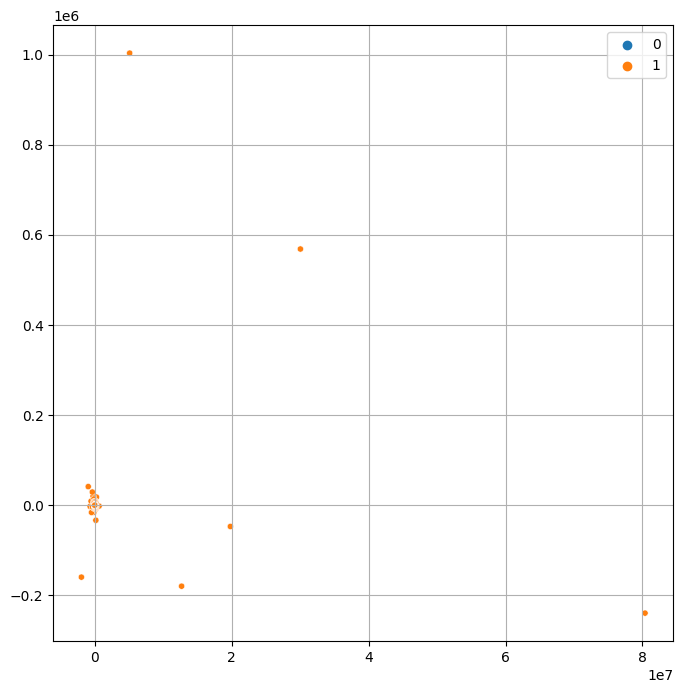

In [17]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_pred)
plt.grid()
plt.savefig("Results/PCA/Botiot")
plt.show()

# Orange ones are anomalies

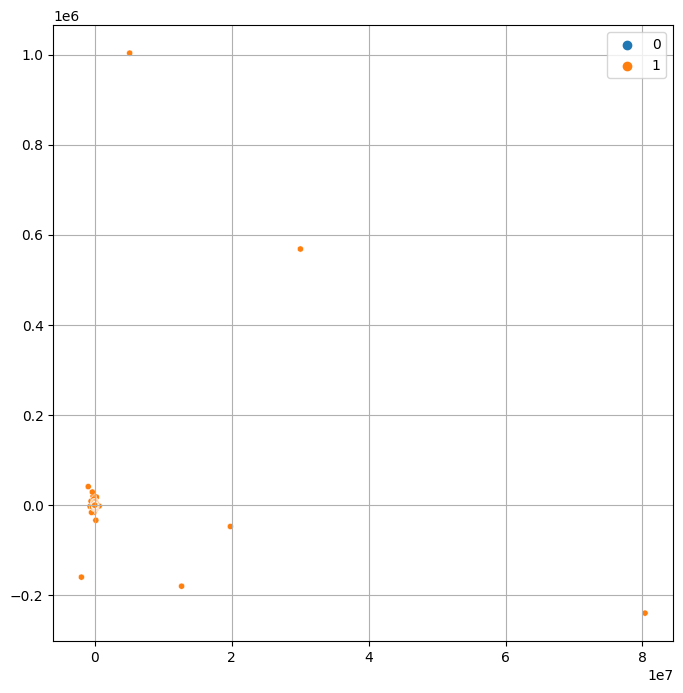

In [18]:
plt.figure(figsize = (8, 8))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test)
plt.grid()
plt.savefig("Results/PCA Groundtruth/Botiot")
plt.show()

# Ground truth

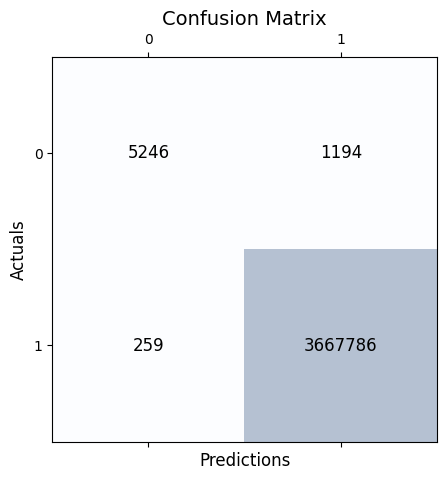

In [19]:
conf_matrix = confusion_matrix(Y_test, Y_pred)

fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.savefig("Results/Confusion Matrix/Botiot")
plt.show()